In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [11]:
df = pd.read_csv('Ready_to_use_data').fillna(' ')
df = df.iloc[np.where((df.department != ' ') & (df.unit != ' '))]

catalogue = pd.read_csv('Ready_to_use_catalogue')

In [12]:
func_1_classes = {}
for num, function in enumerate( df.func_1.unique() ):
    func_1_classes[function] = num

In [13]:
source_vocabulary = ['pad_token']
for string in df.full_description:
    for word in string.split():
        if word in source_vocabulary:
            continue
        else:
            source_vocabulary.append(word)
len(source_vocabulary)

vocab_classes = {}
for code, word in enumerate( source_vocabulary ):
    vocab_classes[word] = code

In [14]:
data = df[['full_description','func_1']]

In [15]:
def description2token(string):
    obj = string.split()
    for i in range(len(obj)):
        obj[i] = vocab_classes[obj[i]]
    return obj

# Кодируем функцию в класс
data.func_1 = data.func_1.map(lambda x: func_1_classes[x])

# Кодируем токены в числа
data.full_description = data.full_description.map(description2token)

In [16]:
data

,full_description,func_1
0,"[1, 2, 3, 4, 5, 6, 7]",0
1,"[8, 9, 10, 11, 6, 12, 7]",1
2,"[9, 13, 3, 14, 15, 6, 12, 16, 17, 18, 19, 20, ...",2
3,"[8, 22, 6, 23, 3, 24, 15, 7]",3
4,"[24, 3, 25, 13, 15, 6, 5, 26, 27, 19, 20, 21, 7]",2
...,...,...
11206,"[6, 15, 96, 3, 43, 8, 94, 5, 409, 748]",4
11207,"[23, 15, 6, 26, 29, 30, 31, 8, 12, 214, 201, 4...",4
11208,"[6, 68, 206, 3, 183, 65, 364, 365, 8, 530]",4
11209,"[6, 15, 96, 3, 43, 8, 94, 5, 748]",4


In [17]:
# Находим максимальную длину описания
maxlen = 0
for obj in data.full_description:
    if len(obj)>maxlen:
        maxlen = len(obj)
    else:
        continue
print(maxlen)

# Ф-я выставления пад-токенов
def padding_func(x, maxlen):
    for i in range(maxlen-len(x)):
        x.append(0) # добавляем ноль так как пад токен == 0
    return x

28


In [18]:
# Выставляем пад-токены для того что бы уровнять все объекты по длине
data.full_description = data.full_description.map(lambda x: padding_func(x, maxlen))

#data = data.to_numpy()

In [19]:
data

,full_description,func_1
0,"[1, 2, 3, 4, 5, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1,"[8, 9, 10, 11, 6, 12, 7, 0, 0, 0, 0, 0, 0, 0, ...",1
2,"[9, 13, 3, 14, 15, 6, 12, 16, 17, 18, 19, 20, ...",2
3,"[8, 22, 6, 23, 3, 24, 15, 7, 0, 0, 0, 0, 0, 0,...",3
4,"[24, 3, 25, 13, 15, 6, 5, 26, 27, 19, 20, 21, ...",2
...,...,...
11206,"[6, 15, 96, 3, 43, 8, 94, 5, 409, 748, 0, 0, 0...",4
11207,"[23, 15, 6, 26, 29, 30, 31, 8, 12, 214, 201, 4...",4
11208,"[6, 68, 206, 3, 183, 65, 364, 365, 8, 530, 0, ...",4
11209,"[6, 15, 96, 3, 43, 8, 94, 5, 748, 0, 0, 0, 0, ...",4


In [23]:
newdata = np.stack([np.array(x) for x in data[:,0]]) #Распаковываем вектора внутри data
newdata = newdata#.reshape(-1, maxlen, 1)
newdata.shape

(11211, 28)

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch

In [25]:
X_train, X_test, y_train, y_test = train_test_split(newdata, data[:,1], test_size=0.3, random_state=0, shuffle=True)

X_train, y_train = torch.IntTensor(X_train), torch.LongTensor(y_train.astype(np.int32))#.view(-1,1)
X_test, y_test = torch.IntTensor(X_test), torch.LongTensor(y_test.astype(np.int32))#.view(-1,1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([7847, 28]),
 torch.Size([3364, 28]),
 torch.Size([7847]),
 torch.Size([3364]))

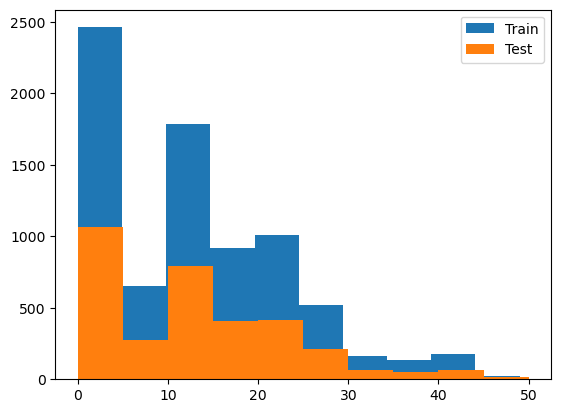

In [26]:
plt.hist(y_train.numpy())
plt.hist(y_test.numpy())
plt.legend(['Train','Test'])

In [122]:
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam, Adadelta, Adagrad, Adamax, RMSprop
from torch.nn import CrossEntropyLoss
import time
from tqdm.autonotebook import tqdm, trange
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [135]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=150, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=150, shuffle=False)

In [165]:
class PositionalEncoding(nn.Module):
    '''
    Позиционное кодирование описания объекта через синусоиду и косинусоиду
    '''
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model) #zero matriz of shape (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) #arange vector of shape (max_len,1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
class TransformerModel(nn.Module):
    '''
    d_model: (EBMEDDING SIZE)
    nhead: Кол-во Single attention heads в Multihead слое
    num_layers: Количество Encoder блоков в слое 
    dropout: The dropout probability.
    vocab_size: размер source словаря
    num_classes: кол-во классов [df.func_1.nunique()]
    '''
    def __init__(self, d_model, nhead, num_layers, dropout, vocab_size, num_classes):
        super(TransformerModel, self).__init__()
        
        self.embedder = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.head1 = nn.Linear(d_model * 28, d_model)
        self.head2 = nn.Linear(d_model, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.embedder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.flatten(1,2)
        x = self.head1(x)
        x = self.head2(x)
        return x

In [166]:
model = TransformerModel(d_model=1024,
                         nhead=16,
                         num_layers=1,
                         dropout=0.25,
                         vocab_size=len(source_vocabulary),
                         num_classes = df.func_1.nunique()).to(device)

In [167]:
# Train the model
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=3e-4)
#scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 50
#early_stop_count = 0
#min_val_loss = float('inf')

train_loss_per_epoch = []
val_loss_per_epoch = []
train_accuracy_per_epoch = []
val_accuracy_per_epoch = []



pbar = trange(epochs, desc="Epoch:")
since = time.time()

for epoch in pbar:
    model.train()
    train_losses = 0
    train_accuracy = 0
    for batch in tqdm(train_loader, leave=False, desc="Train iter:"):
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        train_losses += loss.item()
        optimizer.step()
        train_loss = train_losses/len(train_loader)
        prediction = torch.argmax(outputs, 1)
        train_accuracy += accuracy_score(y_batch.cpu().detach(), prediction.cpu().detach())
    train_loss_per_epoch.append(train_loss)    
    train_accuracy_per_epoch.append(train_accuracy / len(train_loader))
    
    # Validation
    model.eval()
    val_losses = 0
    val_accuracy = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, leave=False, desc="Val iter:"):
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses += loss.item()
            prediction = torch.argmax(outputs, 1)
            val_accuracy += accuracy_score(y_batch.cpu().detach(), prediction.cpu().detach())
    val_loss = val_losses/len(val_loader)
    val_loss_per_epoch.append(val_loss)
    val_accuracy_per_epoch.append(val_accuracy / len(val_loader))
    
    #scheduler.step(val_loss)
    #if val_loss < 0.0002:
        #torch.save(model.state_dict(), f'МОДЕЛИ/Веса для val_loss = {val_loss}' )
    #if val_loss < min_val_loss:
        #min_val_loss = val_loss
        #early_stop_count = 0
    #else:
        #early_stop_count += 1

    #if early_stop_count >= 20:
        #print("Early stopping!")
        #break
    print(f"Epoch {epoch + 1}","/",f"{epochs},Train Loss: {train_loss:.6f} Validation Loss: {val_loss:.6f}")
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    

Epoch::   0%|          | 0/50 [00:00<?, ?it/s]

Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 1 / 50,Train Loss: 4.286850 Validation Loss: 1.804663


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 2 / 50,Train Loss: 1.118211 Validation Loss: 1.404646


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 3 / 50,Train Loss: 0.864316 Validation Loss: 1.331561


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 4 / 50,Train Loss: 0.708005 Validation Loss: 1.305178


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 5 / 50,Train Loss: 0.563574 Validation Loss: 1.150661


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 6 / 50,Train Loss: 0.502842 Validation Loss: 1.149692


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 7 / 50,Train Loss: 0.418853 Validation Loss: 1.159307


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 8 / 50,Train Loss: 0.350009 Validation Loss: 1.109792


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 9 / 50,Train Loss: 0.293273 Validation Loss: 1.182492


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 10 / 50,Train Loss: 0.267006 Validation Loss: 1.141179


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 11 / 50,Train Loss: 0.219939 Validation Loss: 1.218192


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 12 / 50,Train Loss: 0.224322 Validation Loss: 1.201374


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 13 / 50,Train Loss: 0.214983 Validation Loss: 1.188232


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 14 / 50,Train Loss: 0.185269 Validation Loss: 1.270860


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 15 / 50,Train Loss: 0.157970 Validation Loss: 1.244213


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 16 / 50,Train Loss: 0.155576 Validation Loss: 1.284197


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

Val iter::   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 17 / 50,Train Loss: 0.159951 Validation Loss: 1.259803


Train iter::   0%|          | 0/53 [00:00<?, ?it/s]

KeyboardInterrupt: 

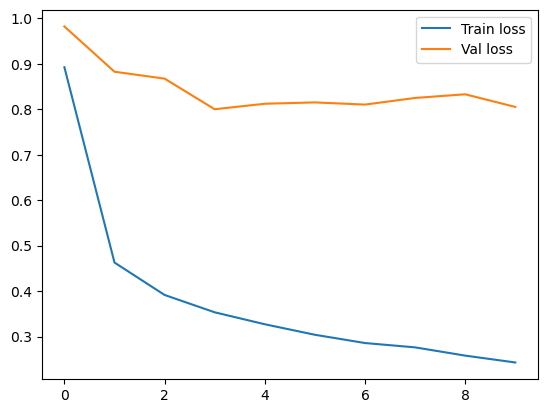

In [140]:
plt.plot(train_loss_per_epoch)
plt.plot(val_loss_per_epoch)
plt.legend(['Train loss','Val loss'])

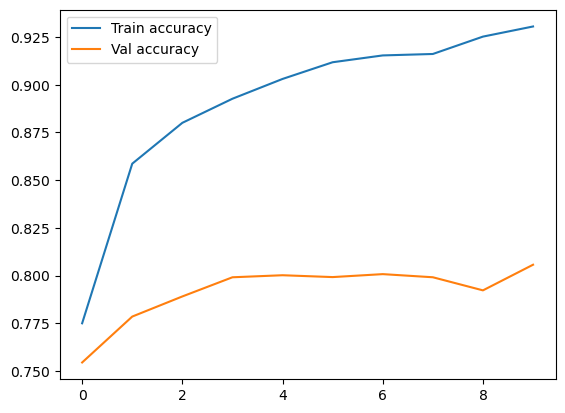

In [141]:
plt.plot(train_accuracy_per_epoch)
plt.plot(val_accuracy_per_epoch)
plt.legend(['Train accuracy','Val accuracy'])

In [131]:
val_accuracy_per_epoch[-1]

0.7444444444444444

In [150]:
torch.save(model.state_dict(), f'MODEL_WEIGHTS/params:[256,4,6,0.1] val_loss = {val_loss} acc = {v}' )